In [ ]:
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/archive.zip (Unzipped Files)/data.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# Entrenando la red con 469 datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
p=9
Ys=np.array(data['diagnosis'])
n=len(Ys)-100
Y=np.zeros(n)
for i in range(n):
  if Ys[i]=='M':
    Y[i]=0
  else:
    Y[i]=1
X11=np.array(data['radius_se'])
X1=np.zeros(n)
for i in range(n):
  X1[i]=X11[i]

X22=np.array(data['texture_se'])
X2=np.zeros(n)
for i in range(n):
  X2[i]=X22[i]

X33=np.array(data['perimeter_se'])
X3=np.zeros(n)
for i in range(n):
  X3[i]=X33[i]

X44=np.array(data['symmetry_se'])
X4=np.zeros(n)
for i in range(n):
  X4[i]=X44[i]

X55=np.array(data['fractal_dimension_se'])
X5=np.zeros(n)
for i in range(n):
  X5[i]=X55[i]

X66=np.array(data['concavity_se'])
X6=np.zeros(n)
for i in range(n):
  X6[i]=X66[i]

X77=np.array(data['concave points_se'])
X7=np.zeros(n)
for i in range(n):
  X7[i]=X77[i]

X88=np.array(data['compactness_se'])
X8=np.zeros(n)
for i in range(n):
  X8[i]=X88[i]

X99=np.array(data['smoothness_se'])
X9=np.zeros(n)
for i in range(n):
  X9[i]=X99[i]

X=np.array([X1,X2,X3,X4,X5,X6,X7,X8,X9]).T


In [ ]:
#plt.scatter(X[Y==0,1],X[Y==0,0],c='skyblue')
#plt.scatter(X[Y==1,1],X[Y==1,0],c='salmon')
#plt.axis('equal')
#plt.show()
Y=Y[:,np.newaxis]

In [ ]:
#Clase de las capas
class capas_neuronales():
  def __init__(self,n_neuronas_anteriores,n_neuronas_actuales,funcion_activacion):
    self.funcion_activacion=funcion_activacion
    #Creamos los parámetros iniciales, los elegimos aleatoriamente
    #self.b=np.random.rand(1,n_neuronas_actuales)-0.5
    #self.W=np.random.rand(n_neuronas_anteriores,n_neuronas_actuales)-.5
    self.b  = np.round(stats.truncnorm.rvs(-1, 1, loc=0, scale=1, size= n_neuronas_actuales).reshape(1,n_neuronas_actuales),3)
    self.W  = np.round(stats.truncnorm.rvs(-1, 1, loc=0, scale=1, size= n_neuronas_actuales * n_neuronas_anteriores).reshape(n_neuronas_anteriores,n_neuronas_actuales),3)
    #Se multiplica por 2 y resta 1 ya que en nuestro caso los datos se encutran al rededor de 0, y necesitamos que vayan de (-1,1) y la función random.rand devuelve valores entre (0,1)

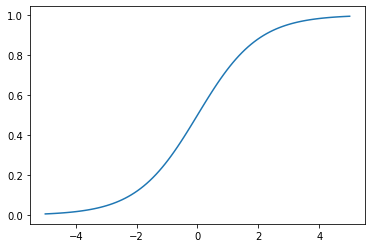

In [ ]:
#FUNCIÓN DE ACTIVACIÓN

sigmoide = (lambda x: 1/(1+np.e**(-x)),
        lambda x:x*(1-x))

#Graficamos las funciones
_x=np.linspace(-5,5,100)
#plt.plot(_x,sigmoide[1](_x))
plt.plot(_x,sigmoide[0](_x))
plt.show()

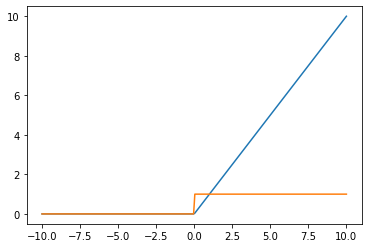

In [ ]:
def derivada_relu(x):
  s=x.copy()
  s[s<=0] = 0
  s[s>0] = 1
  return s
Relu=(lambda x: np.maximum(0,x),
      lambda x: derivada_relu(x))
pp=np.linspace(-10,10,250)
plt.plot(pp,Relu[0](pp))
plt.plot(pp,Relu[1](pp))

In [ ]:
#CAPAS
topologia_red=[p,8,4,1]

#creamos una función que hará las capas de la red
def crear_red(topologia_red,funcion_activacion):
  #Creamos una lista (red neurona(nn)) donde se guardará las capas de la red neuronal
  nn=[]

  #usamos un ciclo donde tendremos el indice, así como el objeto de la lista
  for i,capa in enumerate(topologia_red[:-1]):
    #apendizamos las capas a nn, utilizando la clase capas_neuronales que definimos
    nn.append(capas_neuronales(topologia_red[i],topologia_red[i+1],funcion_activacion))
  return nn 

#ya con la función, la mandamos a llamar con nuestra lista topologia_red y la función sigmoide
crear_red(topologia_red,sigmoide)


In [ ]:
#ENTRENAR A LA RED

#guardamos las capas en una variable
red_neuronal=crear_red(topologia_red,sigmoide)
#defenimos la funión de coste y su derivada
#Yp-valor predicho, Yr-valor real
coste=(lambda Yp, Yr:np.mean((Yp-Yr)**2),
       lambda Yp, Yr: (Yp-Yr))

#definiremos una función donde tendrá la estructura de la red, datos de entrada X, de salida Y, y un radio de aprendizaje (lr)

def entrenar(red_neuronal,X,Y,coste,lr=0.5,train=True):
  #Si train es False lo único que hará la función es una predicción, si es True entonces se ejecuta el entrenamiento, esto se hace si en algún momento no nos interesa que se entrene la red sino una predicción

  #Paso hacia adelante
  #Recordemos que una neurona toma los datos de entrada(en el caso de la primera capa) o los datos de salida como datos de entrada para la siguiente capa.
  #Hace una suma ponderada y la función de activación de esa suma, estos datos como mencionamos serán los de entrada para la suigiente capa y así de manera iterativa
  #Creamos una lista donde guardaremos los datos de salida de cada capa, es decir el valor de la suma ponderada y el valor de la función de activación

  #salida=[(z0,a0),(z1,a1),(z2,a2),...,(zn,an)]
  #Escribimos el primer resultado, donde la suma ponderada para la primera capa es 0 y a0 no es mas que nuestros datos de entrada
  salida=[(None,X)]
  
  for i,capa in enumerate(red_neuronal):
    #realizamos la suma ponderada del ultimo valor de la lista salida de la función e activación para hacer la suma ponderada para cada capa i, también para acceder a W y b usamos la clase capas_neuronales y debemos acceder a ellas con cierta sintaxis
    z=salida[-1][1]@red_neuronal[i].W+red_neuronal[i].b
    #sacamos su función de activación de z, recordemos que sigmoide hay dos funciones definidad, para utilizar la función utilizamos [0] si quisieramos la derivada sería con [1]
    a=red_neuronal[i].funcion_activacion[0](z)
    salida.append((z,a))
    #Algo importante de mencionar es que X no es un número sino una gran cantidad, que representan los datos de entrada a la primera capa
  if train:
    #Paso hacia atras
    #Recordemos que lo que queremos es calcular las deltas, o error en de la última capa y haci retropagar el error
    #Creamos un vector donde guardaremos las deltas o error
    deltas=[]
    #haremos un ciclo que vaya del final al inicio, ya que es la idea de backpropagation
    for i in reversed(range(0,len(red_neuronal))):
      #recordemos que tenemos dos casos diferentes, donde delta se calcula de una manera en la ultima capa y diferente en las demás
      
      #tomamos los valores de z y a de cada capa
      z=salida[i+1][0]
      a=salida[i+1][1]#Salidas por cada capa si fueramos hacia atras

      #primera capa
      if i==len(red_neuronal)-1:
        
        #calcular delta ultima capa
        #escribimos la fórmula de /delta_0(ya demostrada anteriormente) que es la derivada de la función de coste, la cual ya la habíamos escrito en coste[1](segundo término) evaluada en valor predicho (a) y el real(Y) por la derivada de la función de activacion que ya definimos también en sigmoide[1]
        #la insertamos en el indice 0(i.e el primer elemento) 
        #recordemos que la función de activacion ya se encuentra dentro de cada capa y se accede a ella con la sitaxis de clase
        deltas.insert(0,coste[1](a,Y)*red_neuronal[i].funcion_activacion[1](a))
      else:
        #en algunos casos se colocó .T para mutiplicar con la transpuesta ya que si no no es posble el producto matricial
        #calcular delta respecto a capa previa
        #utilizando la formúla para las capas posteriores donde usabamos la delta calculada y la matriz W de la capa igual calculada si estamos en i entonces sería i+1(ver la fórmula de retropagar el error hacia atras)
        deltas.insert(0,deltas[0]@_W.T*red_neuronal[i].funcion_activacion[1](a))
    
      #Ya calculamos backpropagation hasta este punto
      _W=red_neuronal[i].W
      #Gradient descens
      #Como se debe rescribir los valores de b y W en un ciclo que recorra las capas se calcularán dentro del mismo de backpropagation
      #recordemos que cuando escribimos los tres pasos de backpropagation calculamos las derivadas que nos serivirán para el descenso del gradiente, ya que son las mismas que se utilizan y para optimizar p_0(i.e encontar el mínimo) o en este caso optimizar b y W se debe hacer p_0=p_0-lr*gradiente
      #tomemos en cuenta que delta tiene la forma (500,1) (500 valores de n) por lo que restamos la media de los valores del eje de los valores
      #las derivadas de estos parámetros ya tenemos sus fórmulas demostradas
      red_neuronal[i].b=red_neuronal[i].b - np.mean(deltas[0], axis=0, keepdims=True)*lr
      red_neuronal[i].W=red_neuronal[i].W - salida[i][1].T @ deltas[0]*lr

  return salida[-1][1]

entrenar(red_neuronal,X,Y,coste,0.5) 
print('')

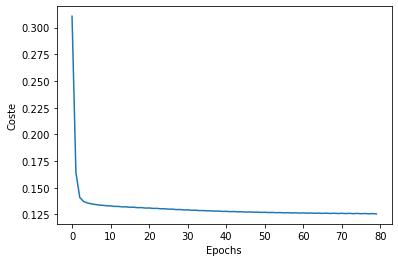

In [ ]:
import time
from IPython.display import clear_output
#Creamos una nueva red
neural_n=crear_red(topologia_red,sigmoide)
#una lista donde se guarden los costes

loss=[]
#Llamamos a train muchas veces
for i in range(2000):
  #Entrenamos a la red
  pY=entrenar(neural_n,X,Y,coste,lr=0.05)

  if i%25==0:
    #cada 25 iteraciones calculamos es coste y lo añadimos a nuestro vector
    loss.append(coste[0](pY,Y))
    

    #generamos una malla 50 x50 y haremos una prediccion por ende train=False
    #la red nos dirá dónde cree que se separan los datos y se visualizaran
    #res=100
    #_x0=np.linspace(0,.50,res)
    #_x1=np.linspace(0,.30,res)
    #_Y=np.zeros((res,res))
    #for i0,x0 in enumerate(_x0):
    #  for i1,x1 in enumerate(_x1):
    #    _Y[i0,i1]=entrenar(neural_n,np.array([[x0,x1]]),Y,coste,train=False)
    #plt.pcolormesh(_x0,_x1,_Y,cmap='coolwarm')
    #plt.axis('equal')


    #plt.scatter(X[Y[:,0]==0,1],X[Y[:,0]==0,0],c='skyblue')
    #plt.scatter(X[Y[:,0]==1,1],X[Y[:,0]==1,0],c='salmon')

    #borra lo anterior y lo suigue ejecutando para que se vea animado
    clear_output(wait=True)
    plt.show()
    plt.plot(range(len(loss)),loss)
    plt.xlabel('Epochs')
    plt.ylabel('Coste')
    plt.show()
    time.sleep(0.1)

In [ ]:
Yp=np.zeros((n,1))
for i in range(len(Yp)):
  if pY[i][0]<.5:
    Yp[i][0]=0
  else:
    Yp[i][0]=1
contador=0
for i in range(len(Yp)):
  if Y[i][0]==Yp[i][0]:
    contador=contador+1
print('El número de datos predichos con existo son:',contador,' de ',len(Yp))
print('El porcentaje de predición es: ',contador/len(pY)*100,'%')


El número de datos predichos con existo son: 390  de  469
El porcentaje de predición es:  83.15565031982942 %


In [ ]:
Yp.shape

(469, 1)

# Probando la red con los 100 datos restantes

In [ ]:
p=9
Ys=np.array(data['diagnosis'])
n=100
Y=np.zeros(n)
for i in range(n):
  if Ys[469+i]=='M':
    Y[i]=0
  else:
    Y[i]=1

X11=np.array(data['radius_se'])
X1=np.zeros(n)
for i in range(n):
  X1[i]=X11[469+i]

X22=np.array(data['texture_se'])
X2=np.zeros(n)
for i in range(n):
  X2[i]=X22[469+i]

X33=np.array(data['perimeter_se'])
X3=np.zeros(n)
for i in range(n):
  X3[i]=X33[469+i]

X44=np.array(data['symmetry_se'])
X4=np.zeros(n)
for i in range(n):
  X4[i]=X44[469+i]

X55=np.array(data['fractal_dimension_se'])
X5=np.zeros(n)
for i in range(n):
  X5[i]=X55[469+i]

X66=np.array(data['concavity_se'])
X6=np.zeros(n)
for i in range(n):
  X6[i]=X66[469+i]

X77=np.array(data['concave points_se'])
X7=np.zeros(n)
for i in range(n):
  X7[i]=X77[469+i]

X88=np.array(data['compactness_se'])
X8=np.zeros(n)
for i in range(n):
  X8[i]=X88[469+i]

X99=np.array(data['smoothness_se'])
X9=np.zeros(n)
for i in range(n):
  X9[i]=X99[469+i]

Xprueba=np.array([X1,X2,X3,X4,X5,X6,X7,X8,X9]).T
Yprueba=entrenar(neural_n,Xprueba,Y,coste,lr=0.05,train=False)

Y=Y[:,np.newaxis]

In [ ]:
Yestimada=np.zeros((n,1))
for i in range(len(Yestimada)):
  if Yprueba[i][0]<.5:
    Yestimada[i][0]=0
  else:
    Yestimada[i][0]=1

contador=0
for i in range(len(Yestimada)):
  if Y[i][0]==Yestimada[i][0]:
    contador=contador+1
print('El número de datos predichos con existo son:',contador,' de ',len(Yestimada))
print('El porcentaje de predición es: ',contador/len(Yestimada)*100,'%')

El número de datos predichos con existo son: 86  de  100
El porcentaje de predición es:  86.0 %
